In [614]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


# Load dataframe and add/clean columns

In [172]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [173]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [174]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

# Regression Formulas

In [477]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
#     #conditional to plot points in diff color depending on game outcome
#     if str(y) == str(reg_df.over_under_line):
#         y1 = y[week5_df['over_under_result']==1]
#         y2 = y[week5_df['over_under_result']==0]
#         y3 = y[week5_df['over_under_result']==2]
#         x1 = x[week5_df['over_under_result']==1]
#         x2 = x[week5_df['over_under_result']==0]
#         x3 = x[week5_df['over_under_result']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
#     else:
#         y1 = y[week5_df['favorite_covered']==1]
#         y2 = y[week5_df['favorite_covered']==0]
#         y3 = y[week5_df['favorite_covered']==2]
#         x1 = x[week5_df['favorite_covered']==1]
#         x2 = x[week5_df['favorite_covered']==0]
#         x3 = x[week5_df['favorite_covered']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [294]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [295]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

# Regression Evaluations

In [296]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [566]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [567]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [568]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

## BoxCox Transformation for Over Under Line

In [569]:
yt,max_lambda =boxcox(week5_df.over_under_line)
yt,max_lambda 

(array([ 9.23234387, 11.05467646,  8.75276538, ...,  9.16534913,
        10.54144152,  9.43049648]), 0.448430037618152)

# Variable 1 -Total Points Against

In [570]:
xt,max_lambda=boxcox(week5_df.total_points_against)
xt,max_lambda

(array([21.7244732, 36.6385492, 21.7244732, ..., 30.4232863, 30.906605 ,
        28.5462582]), 0.886863491729026)

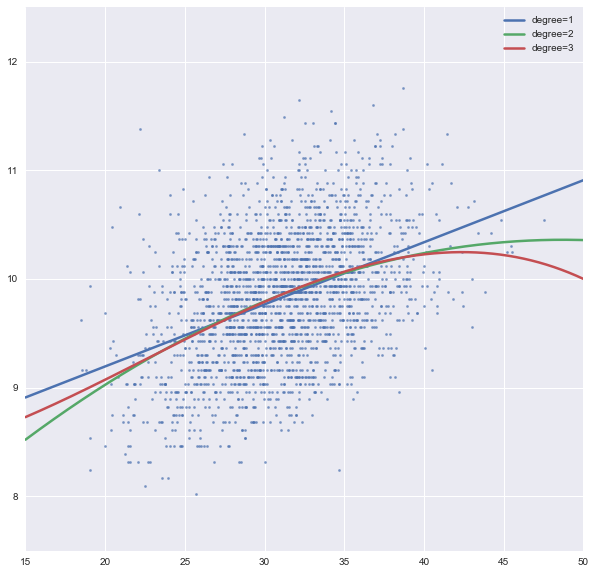

In [571]:
poly_regression(xt, yt,[1,2,3], 15,50, 7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     436.8
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           4.75e-89
Time:                        16:43:52   Log-Likelihood:                -1904.0
No. Observations:                2332   AIC:                             3812.
Df Residuals:                    2330   BIC:                             3824.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.2158 

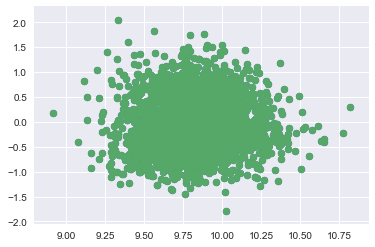

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.5474614195162254, check =0.0


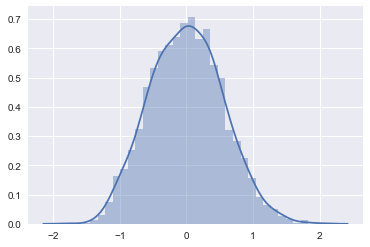

In [572]:
regression_evaluation(yt,week5_df.total_points_against)

# Variable 2 - Total PPG

In [573]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.total_ppg)
xt,x_lambda

(array([13.4601341 , 16.13883891, 11.40031543, ..., 11.57295782,
        12.88453373, 12.86193603]), 0.5300643195053278)

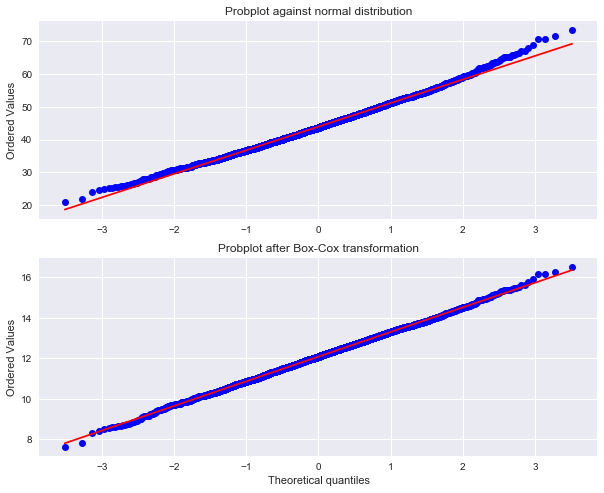

In [574]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
x = week5_df.total_ppg
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

In [575]:
week5_df.total_ppg.head()

5431    52.17
5432    70.67
5433    39.75
5434    39.42
5435    28.00
Name: total_ppg, dtype: float64

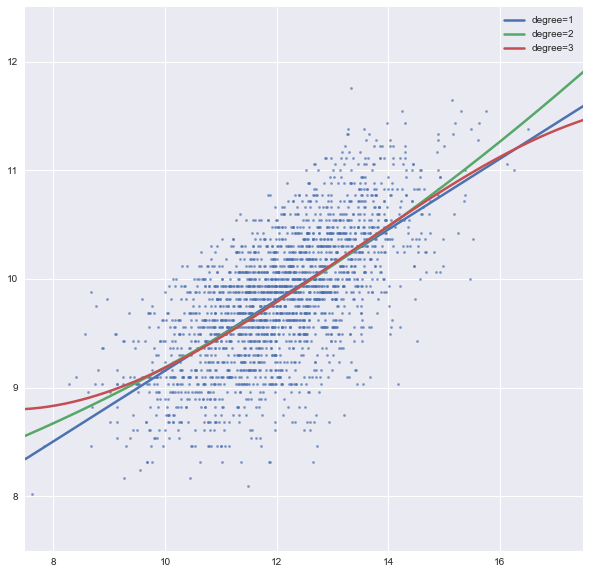

In [576]:
poly_regression(xt,yt,[1,2,3],7.5,17.5,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1692.
Date:                Sat, 11 Aug 2018   Prob (F-statistic):          1.54e-278
Time:                        16:43:53   Log-Likelihood:                -1467.8
No. Observations:                2332   AIC:                             2940.
Df Residuals:                    2330   BIC:                             2951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9336      0.095     62.409      0.0

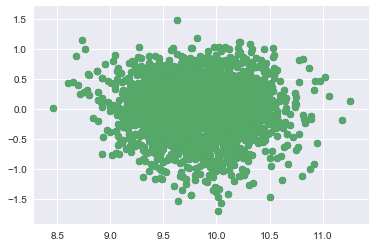

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.45406549515238354, check =0.0


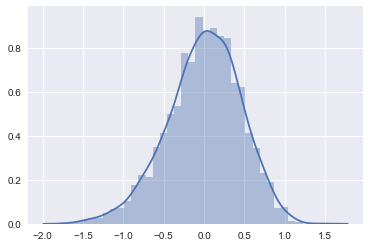

In [577]:
regression_evaluation(yt,xt)

# Variable 3 - Weather Temperature

In [578]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_temperature+1)
xt,x_lambda


(array([694.60313503, 449.39456784, 679.04671569, ..., 269.20135024,
        679.04671569, 111.45770551]), 1.6406956315527044)

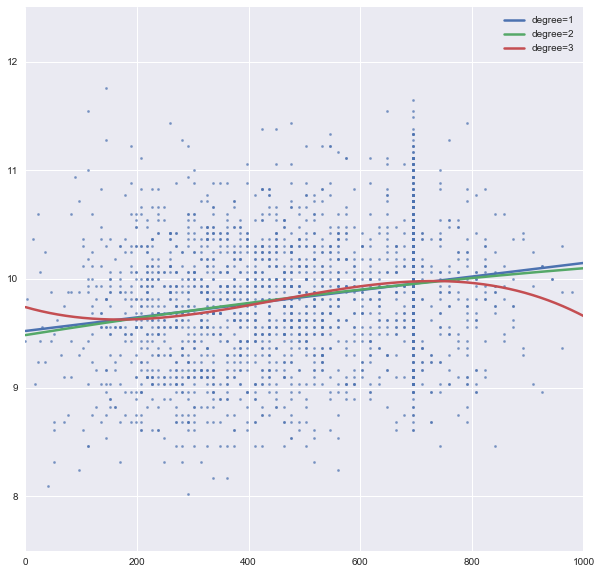

In [579]:
poly_regression(xt,yt,[1,2,3],0,1000,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     106.0
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           2.46e-24
Time:                        16:43:54   Log-Likelihood:                -2052.5
No. Observations:                2332   AIC:                             4109.
Df Residuals:                    2330   BIC:                             4121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5178      0.032    295.380      0.0

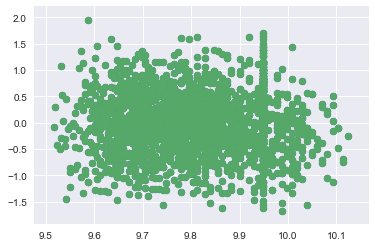

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.5834565349296975, check =0.0


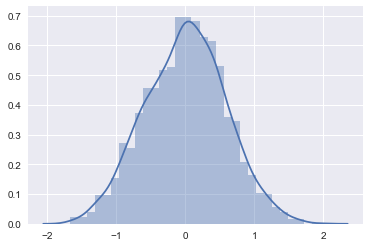

In [580]:
regression_evaluation(yt,xt)

# Variable 4 - Weather Wind mph

In [581]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_wind_mph+1)
xt,x_lambda

(array([0.        , 3.57462433, 3.08597593, ..., 3.08597593, 1.79452781,
        2.51089121]), 0.3576256637087338)

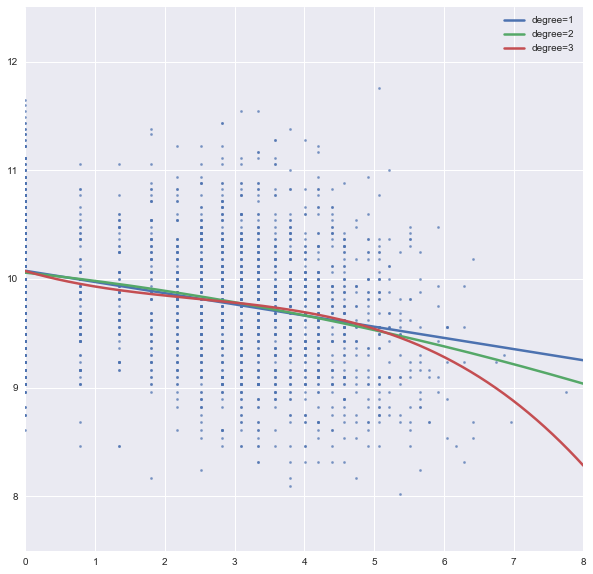

In [582]:
poly_regression(xt,yt,[1,2,3],0,8,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     243.8
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           2.35e-52
Time:                        16:43:55   Log-Likelihood:                -1988.3
No. Observations:                2332   AIC:                             3981.
Df Residuals:                    2330   BIC:                             3992.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0865      0.020    493.277      0.0

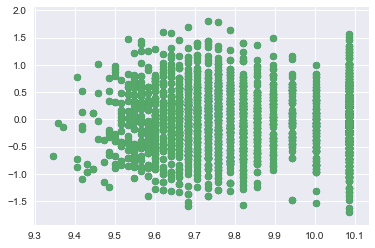

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.5676165948128781, check =0.0


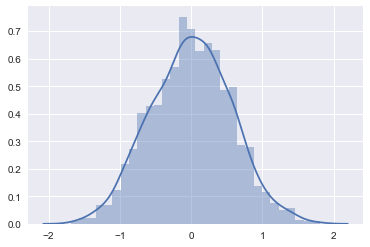

In [583]:
regression_evaluation(yt,xt)

# Variable 5 - Weather Humidity

In [584]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_humidity)
xt,x_lambda

(array([1031.33427609, 1100.33702558, 1187.57929133, ..., 1031.33427609,
        1031.33427609, 1031.33427609]), 1.791916296742925)

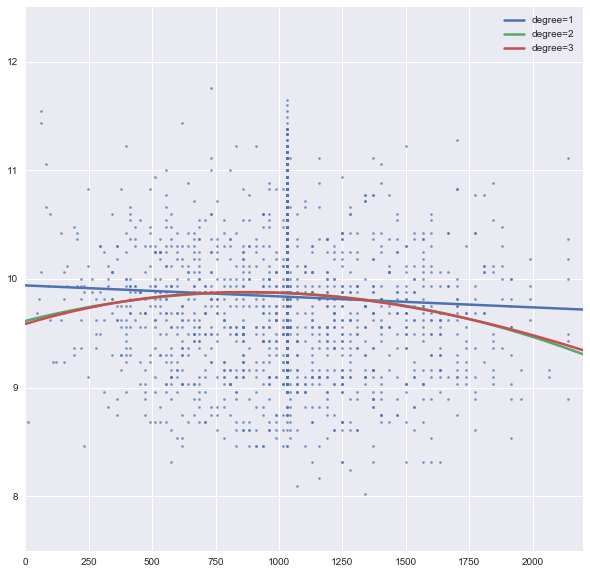

In [585]:
poly_regression(xt,yt,[1,2,3],0,2200,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.099
Date:                Sat, 11 Aug 2018   Prob (F-statistic):            0.00777
Time:                        16:43:58   Log-Likelihood:                -2100.8
No. Observations:                2332   AIC:                             4206.
Df Residuals:                    2330   BIC:                             4217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9275      0.040    246.376      0.0

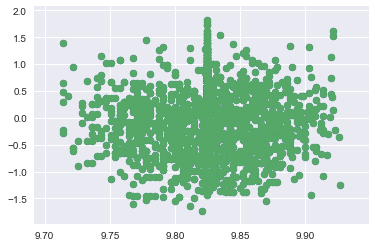

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.5956713033401922, check =0.0


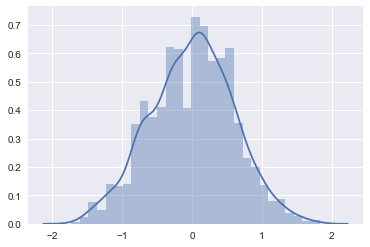

In [586]:
regression_evaluation(yt,xt)

# Regression of over under with all variables

In [604]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt1,xlam1 = boxcox(week5_df.total_points_against)
xt2,xlam2 = boxcox(week5_df.total_ppg)
xt3,xlam3 = boxcox(week5_df.weather_temperature+1)
xt4,xlam4 = boxcox(week5_df.weather_wind_mph+1)
xt5,xlam5 = boxcox(week5_df.weather_humidity)
ou_regression_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
ou_regression_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
ou_regression_df.head()

,Total Points Against,Total PPG,Temp,Wind MPH,Humidity
0,21.724473,13.460134,694.603135,0.000000,1031.334276
1,36.638549,16.138839,449.394568,3.574624,1100.337026
2,21.724473,11.400315,679.046716,3.085976,1187.579291
3,29.952122,11.341732,476.063536,3.795520,1071.911229
4,26.932846,9.148079,790.798541,4.003863,732.716377


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     1033.
Date:                Sat, 11 Aug 2018   Prob (F-statistic):               0.00
Time:                        16:59:50   Log-Likelihood:                -741.07
No. Observations:                2332   AIC:                             1494.
Df Residuals:                    2326   BIC:                             1529.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.7817 

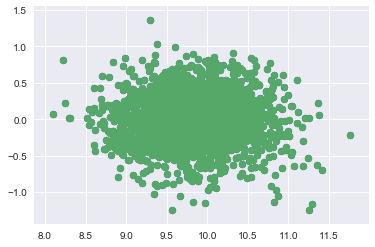

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.3324861714037072, check =0.0


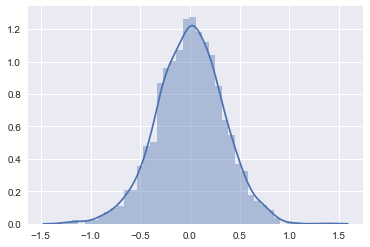

In [613]:
regression_evaluation(yt,ou_regression_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     1039.
Date:                Sat, 11 Aug 2018   Prob (F-statistic):               0.00
Time:                        16:58:54   Log-Likelihood:                -736.39
No. Observations:                2332   AIC:                             1485.
Df Residuals:                    2326   BIC:                             1519.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.4530 

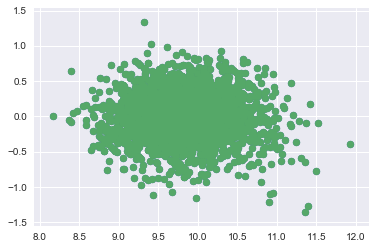

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.33182048238076095, check =0.0


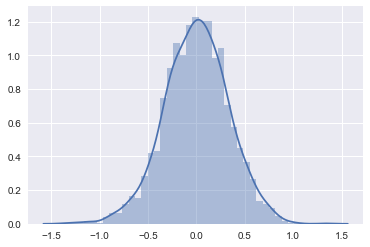

In [603]:
regression_evaluation(yt,week5_df[['weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']])

# Distribution of Scores

In [185]:
scores_df = week5_df[['score_home','score_away']]

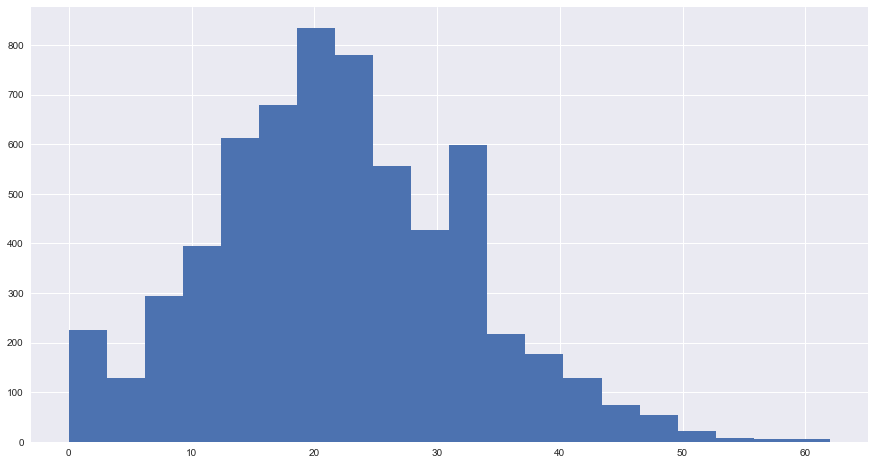

In [186]:
plt.figure(figsize=(15,8))
plt.hist(all_scores,bins=20);

In [200]:
home_scores = list(scores_df.score_home)
away_scores = list(scores_df.score_away)
all_scores = []
all_scores.extend(home_scores)
all_scores.extend(away_scores)
all_scores=np.array(all_scores)

In [188]:
len(all_scores)

6220

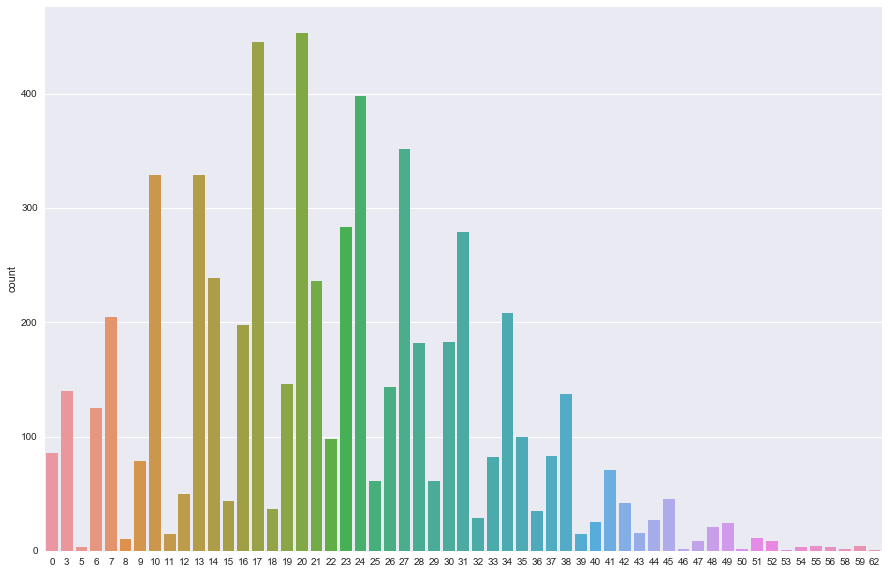

In [189]:
import collections
score_freq = collections.Counter(all_scores)
score_freq

from operator import itemgetter  

# for key, value in sorted(score_freq.items(), key = itemgetter(1), reverse = True):
#     print(key, value)

plt.figure(figsize=(15,10))
sns.countplot(all_scores)

In [190]:
factor = FactorAnalysis(n_components=5).fit(scores_df)

In [191]:
factor.components_

array([[ 8.05296419, -6.7499898 ],
       [ 6.3429705 ,  7.56737653]])

In [227]:
9^8

1

(array([ 9.23234387, 11.05467646,  8.75276538, ...,  9.16534913,
        10.54144152,  9.43049648]), 0.448430037618152)